<a href="https://colab.research.google.com/github/oldliuwill/TRI/blob/main/LSTM_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving 699-25612-0002-205_C24_T_C_ATE01_25612-B00-WB09.csv to 699-25612-0002-205_C24_T_C_ATE01_25612-B00-WB09 (2).csv
Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9410 - loss: 0.4819
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9970 - loss: 0.0286
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9974 - loss: 0.0191
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9942 - loss: 0.0357
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9942 - loss: 0.0358
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9966 - loss: 0.0228
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9987 - loss: 0.0107
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9964 - loss: 0.0240
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9952 - loss: 0.0313
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9988 - loss: 0.0097
Epoch 11/20
24/24 ━━━━━━━━━━━━━

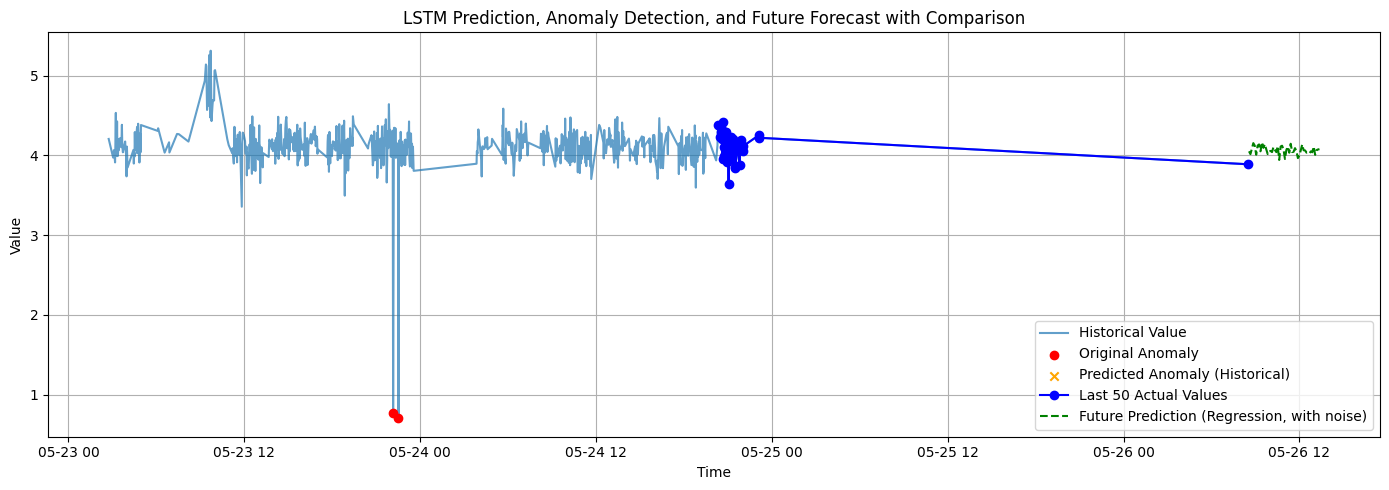

In [8]:
# 📌 Step 1: 上傳 CSV 檔案
from google.colab import files
uploaded = files.upload()

# 📌 Step 2: 套件與資料處理
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
# Import Input and Dropout
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
import os # Import the os module

# 📌 Step 3: 讀取 CSV，第 5-7 欄
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename, header=None)
df = df.iloc[:, [4, 5, 6]]
df.columns = ['InspectTime', 'MeasureValue', 'InspectResult']

# 嘗試將 'InspectTime' 轉換為日期時間格式，將無法解析的值轉換為 NaT
# 假設原始時間列在 CSV 中的索引是 4 (基於 df.iloc[:, [4, 5, 6]] 和 df.columns)
original_time_column_index = 4
invalid_time_rows_before_dropna = df[pd.to_datetime(df['InspectTime'], errors='coerce').isna()].copy()

df['InspectTime'] = pd.to_datetime(df['InspectTime'], errors='coerce')

# 找出無法解析的列並打印
if not invalid_time_rows_before_dropna.empty:
    print("以下是無法解析為日期時間的原始值及其索引:")
    # Use the original column index if possible, or use the 'InspectTime' column from the temp df
    print(invalid_time_rows_before_dropna['InspectTime'].to_string())

# 移除無法解析的列
df = df.dropna(subset=['InspectTime']).reset_index(drop=True) # Reset index after dropping

# 轉換結果為二值：9 -> 0（正常）、其他 -> 1（異常）
df['IsAnomaly'] = df['InspectResult'].apply(lambda x: 0 if x == 9 else 1)

# 📌 Step 4: 資料正規化
scaler = MinMaxScaler()
# Fit scaler on the entire MeasureValue column *before* creating sequences
scaled_values = scaler.fit_transform(df[['MeasureValue']])

# --- Anomaly Detection Model Data Preparation ---
# 建立 LSTM 訓練資料（使用前 look_back 筆量測預測是否異常）
look_back_anomaly = 30 # Use a specific look_back for anomaly detection if needed, or keep the same
X_anomaly, y_anomaly = [], []
# Iterate through the scaled values to create sequences and corresponding anomaly labels
for i in range(look_back_anomaly, len(scaled_values)):
    X_anomaly.append(scaled_values[i-look_back_anomaly:i, 0])
    y_anomaly.append(df['IsAnomaly'].iloc[i]) # y corresponds to the label *at* the end of the sequence

X_anomaly = np.array(X_anomaly).reshape(-1, look_back_anomaly, 1)
y_anomaly = np.array(y_anomaly)

# --- Regression Model Data Preparation ---
# 建立 LSTM 訓練資料 (改為預測下一個數值)
look_back_reg = 50 # Use a specific look_back for regression if needed, or keep the same
X_reg, y_reg = [], [] # Use different variable names for regression data
# Iterate through the scaled values to create sequences and the *next scaled value*
for i in range(look_back_reg, len(scaled_values)):
    X_reg.append(scaled_values[i-look_back_reg:i, 0])
    y_reg.append(scaled_values[i, 0]) # y corresponds to the *next scaled value*

X_reg = np.array(X_reg).reshape(-1, look_back_reg, 1)
y_reg = np.array(y_reg)


# 📌 Step 5: 建立異常預測 LSTM 模型（分類）
model_anomaly = Sequential([
    Input(shape=(look_back_anomaly, 1)), # Add Input layer specifying the shape
    LSTM(64, return_sequences=True), # Return sequences for the next LSTM layer
    Dropout(0.2), # Add a Dropout layer
    LSTM(32, return_sequences=False), # Another LSTM layer
    Dense(1, activation='sigmoid') # Output layer with sigmoid for binary classification
])
model_anomaly.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_anomaly.fit(X_anomaly, y_anomaly, epochs=20, batch_size=32, verbose=1) # Increase epochs for potentially better learning

# 📌 Step 5.1: 建立時間序列預測 LSTM 模型 (迴歸)
# Create a new model for regression
model_reg = Sequential([
    Input(shape=(look_back_reg, 1)), # Input layer
    LSTM(64, return_sequences=True), # Return sequences for the next LSTM layer
    Dropout(0.2), # Dropout layer
    LSTM(32, return_sequences=False), # Another LSTM layer
    Dense(1) # Output layer with 1 neuron for regression (predicting a single value)
    # No activation function here for linear output, or 'linear' activation
])

# Compile the regression model
model_reg.compile(optimizer='adam', loss='mse') # Use Mean Squared Error for regression

# Train the regression model
# Use X_reg and y_reg for training
model_reg.fit(X_reg, y_reg, epochs=20, batch_size=32, verbose=1)


# 📌 Step 5.5: 儲存訓練好的模型 (Both models if desired, or just the one needed later)
# Saving the anomaly model (optional, but good practice)
model_anomaly_save_path = 'lstm_anomaly_model.keras'
model_anomaly.save(model_anomaly_save_path)
print(f"Anomaly detection model saved to {model_anomaly_save_path}")

# Saving the regression model
model_reg_save_path = 'lstm_regression_model.keras' # Define a new path for the regression model
model_reg.save(model_reg_save_path) # Save the regression model
print(f"Regression model saved to {model_reg_save_path}")


# 📌 Step 6: 進行異常預測 (Using the anomaly detection model)
# Predict anomalies using the anomaly model on the anomaly dataset
y_pred_anomaly_prob = model_anomaly.predict(X_anomaly).flatten()
y_pred_anomaly_label = (y_pred_anomaly_prob > 0.5).astype(int) # Convert probabilities to binary labels

# Corresponding time and value data for the historical anomaly predictions
# These indices should correspond to the y_anomaly values, which are at index look_back_anomaly and beyond
predict_times_anomaly = df['InspectTime'].iloc[look_back_anomaly:].reset_index(drop=True)
measure_value_slice_anomaly = df['MeasureValue'].iloc[look_back_anomaly:].reset_index(drop=True)
real_label_slice_anomaly = df['IsAnomaly'].iloc[look_back_anomaly:].reset_index(drop=True)
# y_pred_anomaly_label is already aligned with predict_times_anomaly and real_label_slice_anomaly


# 📌 Step 7: 預測未來 50 筆量測值 (Using the regression model)
num_future_steps = 50
# Start future prediction from the last 'look_back_reg' values of the scaled data
current_prediction_input_reg = scaled_values[-look_back_reg:].reshape(1, look_back_reg, 1)
future_predictions_scaled_reg = []

for _ in range(num_future_steps):
    # Predict the next scaled value using the regression model
    predicted_value_scaled_reg = model_reg.predict(current_prediction_input_reg, verbose=0)[0][0] # Set verbose=0 to hide prediction progress
    future_predictions_scaled_reg.append(predicted_value_scaled_reg)

    # Update the input sequence for the next prediction
    predicted_value_reshaped_reg = np.array([[predicted_value_scaled_reg]]).reshape(1, 1, 1)
    current_prediction_input_reg = np.append(current_prediction_input_reg[:, 1:, :], predicted_value_reshaped_reg, axis=1)

# Inverse transform the scaled future predictions
future_predictions_reg = scaler.inverse_transform(np.array(future_predictions_scaled_reg).reshape(-1, 1)).flatten()

# Add some noise to the future predictions for visualization (Optional)
noise_level = 0.05 # Adjust this value
noise_reg = np.random.normal(0, noise_level, future_predictions_reg.shape)
future_predictions_with_noise_reg = future_predictions_reg + noise_reg

# Generate future timestamps (Keep the same logic)
last_time = df['InspectTime'].iloc[-1]
# Calculate the average time delta to project future times
# Handle the case where df is empty or has only one point
if len(df) > 1:
    time_delta = df['InspectTime'].diff().mean()
else:
    # If only one point, assume a default time delta or handle appropriately
    # For this scenario, with look_back > 1, this case is unlikely if model fitting succeeded
    time_delta = pd.Timedelta(minutes=1) # Example default

future_times = [last_time + (i + 1) * time_delta for i in range(num_future_steps)]
future_times = pd.to_datetime(future_times)

# --- Extract the last 50 actual values and their times ---
# Get the last num_future_steps rows of the original DataFrame
last_actual_data = df.tail(num_future_steps).reset_index(drop=True)
last_actual_times = last_actual_data['InspectTime']
last_actual_values = last_actual_data['MeasureValue']


# 📌 Step 8 & 9: 畫圖比較並加入未來預測和歷史預測
plt.figure(figsize=(14, 5))
# Plot the entire historical data
plt.plot(df['InspectTime'], df['MeasureValue'], label='Historical Value', alpha=0.7) # Add alpha for clarity

# Add scatter plot for original anomaly points
# Filter the DataFrame for rows where 'IsAnomaly' is 1
anomaly_points_original = df[df['IsAnomaly'] == 1]
plt.scatter(anomaly_points_original['InspectTime'], anomaly_points_original['MeasureValue'],
            color='red', label='Original Anomaly', zorder=5) # Use zorder to ensure dots are on top

# Add scatter plot for predicted anomaly points (historical)
# Filter the historical data slice for points predicted as anomaly
predicted_anomaly_points = measure_value_slice_anomaly[y_pred_anomaly_label == 1]
predicted_anomaly_times = predict_times_anomaly[y_pred_anomaly_label == 1]
plt.scatter(predicted_anomaly_times, predicted_anomaly_points,
            color='orange', label='Predicted Anomaly (Historical)', marker='x', zorder=6) # Use marker='x' and a different zorder

# Plot the last 50 actual values
plt.plot(last_actual_times, last_actual_values, color='blue', linestyle='-', marker='o', label='Last 50 Actual Values')

# Plot future predictions from the regression model
plt.plot(future_times, future_predictions_with_noise_reg, color='green', linestyle='--', label='Future Prediction (Regression, with noise)')

plt.title('LSTM Prediction, Anomaly Detection, and Future Forecast with Comparison')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
